In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Набор данных содержит количество общественных велосипедов, арендованных в час в Сеульской системе проката велосипедов, с соответствующими данными о погоде и информацией о праздниках.
Датасет: https://archive-beta.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

```
Атрибуты:
Date : year-month-day
Rented Bike count - Count of bikes rented at each hour
Hour - Hour of he day
Temperature-Temperature in Celsius
Humidity - %
Windspeed - m/s
Visibility - 10m
Dew point temperature - Celsius 
Solar radiation - MJ/m2
Rainfall - mm
Snowfall - cm
Seasons - Winter, Spring, Summer, Autumn
Holiday - Holiday/No holiday
Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)
```




In [32]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
#Add encoding = 'unicode_escape'
df = pd.read_csv("/content/drive/MyDrive/Dataset/Seoul Bike Sharing/SeoulBikeData.csv", encoding = 'unicode_escape').drop(["Date", "Holiday", "Seasons"], axis=1)

In [33]:
df.head(5)

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [34]:
df.columns =  dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int) # conver functional (Yes/no in 1 or 0)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)
df.head(5)

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike count at Noon")
  plt.xlabel(label)
  plt.show()


In [35]:
# Drop no interesting data
df = df.drop(["wind", "visibility", "functional"], axis = 1)
df.head(5)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Тренировочная/Валидационная/Тестовая выборка

In [37]:
train, valid, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

In [86]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!= y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[[x_labels][0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values
  
  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X,y



In [87]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels= ["temp"])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels= ["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels= ["temp"])

In [43]:
temp_regress = LinearRegression()
temp_regress.fit(X_train_temp, y_train_temp)

LinearRegression()

In [44]:
print(temp_regress.coef_, temp_regress.intercept_)

[[21.70609385]] [354.33239637]


In [46]:
temp_regress.score(X_test_temp, y_test_temp)

0.2326796997253191

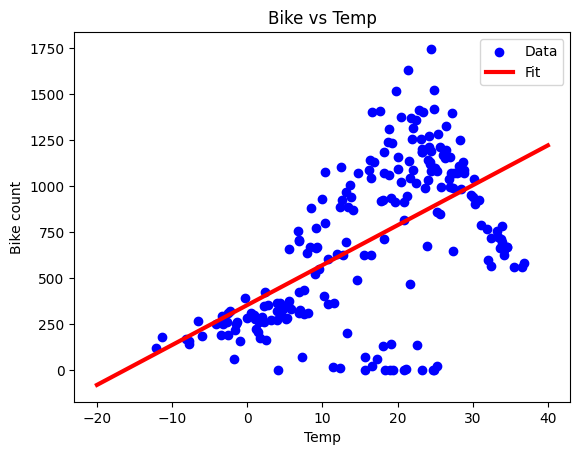

In [55]:
plt.scatter(X_train_temp, y_train_temp, label ="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_regress.predict(np.array(x).reshape(-1,1)), label ="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [56]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [62]:
_, X_train, y_train = get_xy(train, "bike_count", x_labels= df.columns[1:])
_, X_valid, y_valid = get_xy(valid, "bike_count", x_labels= df.columns[1:])
_, X_test, y_test = get_xy(test, "bike_count", x_labels= df.columns[1:])

In [69]:
all_regress = LinearRegression()
all_regress.fit(X_train, y_train)

LinearRegression()

In [70]:
all_regress.score(X_test, y_test)

0.4335340127128642

# Regression with NN

In [91]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [75]:
# get normalize layer
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))


In [79]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [83]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.1), loss = "mean_squared_error")

In [88]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data=(X_valid_temp, y_valid_temp)
)

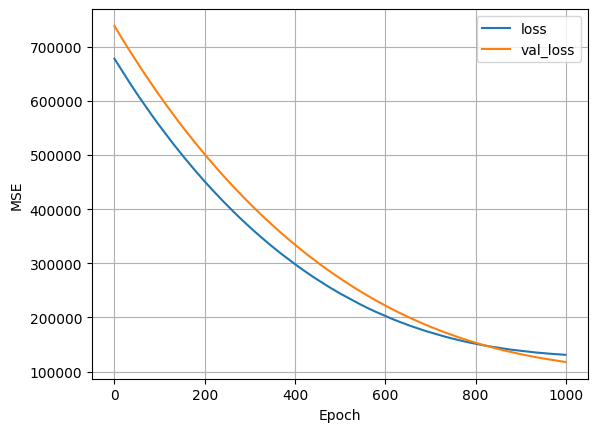

In [92]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


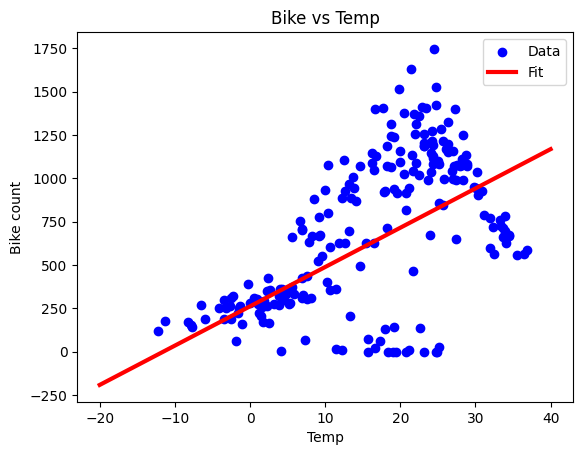

In [93]:
plt.scatter(X_train_temp, y_train_temp, label ="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label ="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

# Neaural Net

In [103]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [107]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model_v2 = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [104]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_valid_temp, y_valid_temp),
    verbose=0, epochs=100
)

In [108]:
history_v2 = nn_model_v2.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_valid_temp, y_valid_temp),
    verbose=0, epochs=100
)

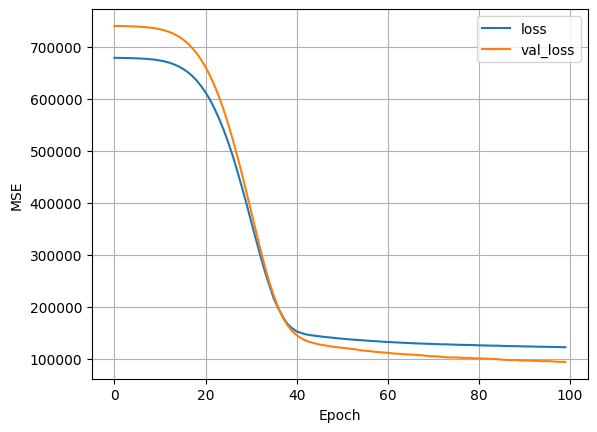

In [105]:
plot_loss(history)

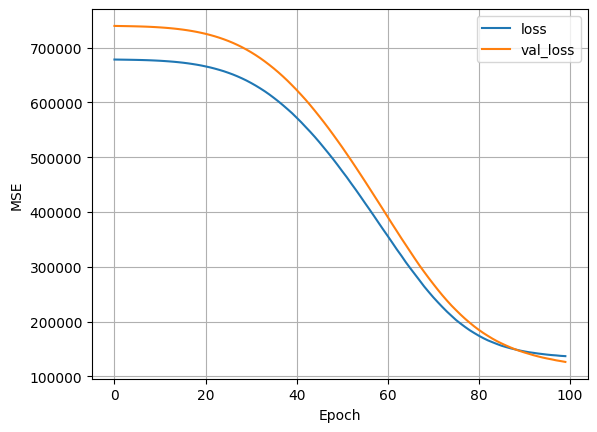

In [109]:
plot_loss(history_v2)

4/4 [==============================] - 0s 4ms/step


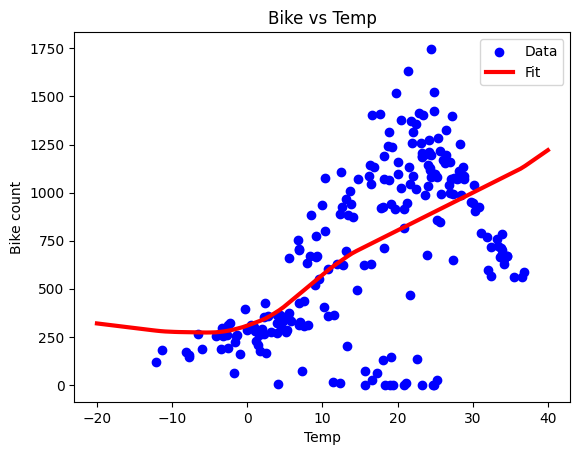

4/4 [==============================] - 0s 4ms/step


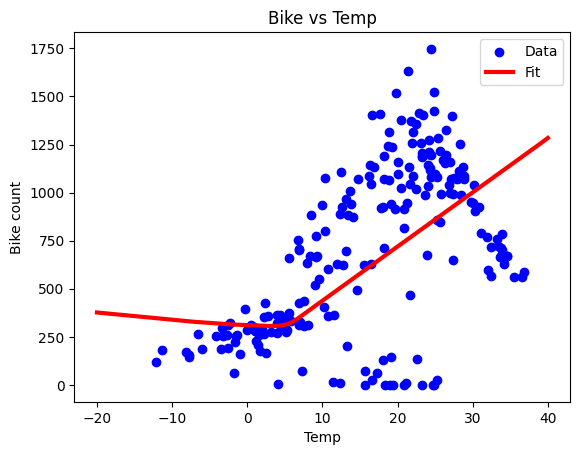

In [110]:
plt.scatter(X_train_temp, y_train_temp, label ="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label ="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()



plt.scatter(X_train_temp, y_train_temp, label ="Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model_v2.predict(np.array(x).reshape(-1,1)), label ="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bike vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

#Multiple In NN

In [131]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train)

In [132]:
nn_model_all = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [133]:
history_all = nn_model_all.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    verbose=0, epochs=100
)

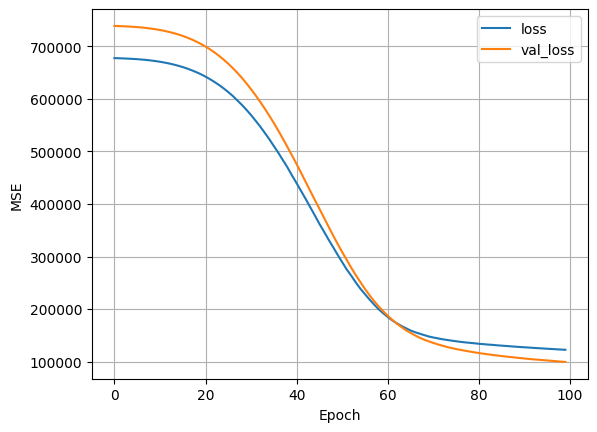

In [134]:
plot_loss(history_all)

In [135]:
# расчет MSE для линейной регрессии(LR) и Сети (NN)
y_pred_lr = all_regress.predict(X_test)
y_pred_nn = nn_model_all.predict(X_test)

3/3 [==============================] - 0s 4ms/step


In [136]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [138]:
print(MSE(y_pred= y_pred_lr, y_real = y_test))
print(MSE(y_pred= y_pred_nn, y_real = y_test))


109390.57101617685
134344.98615840825


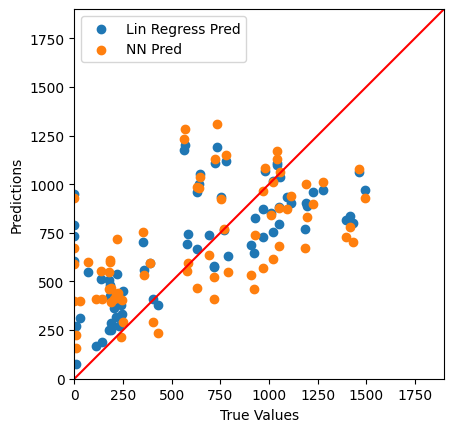

In [141]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test, y_pred_lr, label = "Lin Regress Pred")
plt.scatter(y_test, y_pred_nn, label = "NN Pred")

plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0,1900]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')
plt.show()